In [1]:
from sentence_transformers import SentenceTransformer
import random
import nltk
import dspy
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import pipeline
import re
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib.cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
nltk.download('punkt')
nltk.download('stopwords')

import os
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device=device)
embedder = dspy.Embedder(model.encode)
df = pd.read_excel("data/tell_me_again_df_with_elements_v6.xlsx")
df = df.dropna()

<All keys matched successfully>


In [3]:
df.property_count.max()

np.int64(8)

In [4]:
len(list(set(df.title.tolist())))

1200

In [5]:
def create_category_string(category, dictionary):
    string = f"{category}: "

    if category in dictionary:
        category_data = dictionary[category]
        if isinstance(category_data, list):
            for item in category_data:
                for k, v in item.items():
                    if k == 'name':
                        continue
                    if isinstance(v, list):
                        v = ', '.join(v)
                    string += f"{k}: {v} "
        elif isinstance(category_data, dict):
            for k, v in category_data.items():
                if k == 'name':
                    continue
                if isinstance(v, list):
                    v = ', '.join(v)
                string += f"{k}: {v} "
        else:
            string += f"{category}: {category_data} "

    return string.strip()


def transform_dict_to_strings(data):
    result = {}

    for category in data:
        result[category] = create_category_string(category, data)

    return result


In [6]:
class CharacterAnonymizer:
    def __init__(self, batch_size=16):
        self.ner_pipeline = pipeline(
            "ner",
            model="Jean-Baptiste/roberta-large-ner-english",
            aggregation_strategy="simple",
            device=0
        )
        self.batch_size = batch_size

    def normalize_name(self, name):
        name = name.lower()
        name = re.sub(r"[^a-z ]", "", name)
        return name.strip()

    def extract_names_batch(self, texts):
        ner_results_batch = self.ner_pipeline(texts)
        all_names = []
        for ner_results in ner_results_batch:
            names = [ent['word'] for ent in ner_results if ent['entity_group'] == 'PER']
            normalized = list(set(self.normalize_name(name) for name in names))
            all_names.append(normalized)
        return all_names

    def cluster_names(self, names):
        clusters = defaultdict(list)
        used = set()

        for name in names:
            if not name.strip():
                continue
            if name in used:
                continue
            parts = name.split()
            if not parts:
                continue
            key = parts[0]
            for other in names:
                if key in other and other not in used:
                    clusters[key].append(other)
                    used.add(other)
        return clusters

    def generate_name_map(self, clusters):
        name_map = {}
        for i, (key, variants) in enumerate(clusters.items(), start=1):
            tag = f"Character{i}"
            for name in variants:
                name_map[name] = tag
        return name_map

    def replace_names(self, text, name_map):
        for original in sorted(name_map.keys(), key=len, reverse=True):
            pattern = re.compile(rf'\b{re.escape(original)}\b', re.IGNORECASE)
            text = pattern.sub(name_map[original], text)
        return text

    def anonymize_batch(self, texts):
        anonymized_texts = []

        for i in tqdm(range(0, len(texts), self.batch_size), desc="Anonymizing"):
            batch = texts[i:i + self.batch_size]
            all_names = self.extract_names_batch(batch)

            for text, names in zip(batch, all_names):
                clusters = self.cluster_names(names)
                name_map = self.generate_name_map(clusters)
                anonymized = self.replace_names(text, name_map)
                anonymized_texts.append(anonymized)

        return anonymized_texts


In [7]:
def build_index(embeddings, normalize_vectors=True):
    if normalize_vectors:
        return normalize(embeddings, axis=1)
    return embeddings


def get_dense_similarity(query_vector, candidate_vectors):
    if query_vector.ndim == 1:
        query_vector = query_vector.reshape(1, -1)
    return np.dot(candidate_vectors, query_vector.T).flatten()

def get_relevance_scores(i, labels, index):
    matching_label = labels[i]

    query_vector = index[i].reshape(1, -1)
    similarities = get_dense_similarity(query_vector, index).flatten()

    relevance_scores = np.array([1 if x == matching_label else 0 for x in labels])
    similarity_scores = similarities

    mask = np.arange(len(labels)) != i

    relevance_scores = relevance_scores[mask]
    similarity_scores = similarity_scores[mask]

    return relevance_scores.tolist(), similarity_scores.tolist()


def calculate_mean_ndcg_score(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    scores = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)
        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)
        #k = relevance_scores.sum()
        k = None
        scores.append(ndcg_score([relevance_scores], [similarity_scores], k=k))

    return np.mean(scores)


def calculate_mean_recall(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    recalls = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)

        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)

        k = relevance_scores.sum()
        if k == 0:
            continue

        sorted_indices = np.argsort(-similarity_scores)

        top_k_indices = sorted_indices[:k]

        top_k_relevance = relevance_scores[top_k_indices]

        recall = top_k_relevance.sum() / k
        recalls.append(recall)

    if len(recalls) == 0:
        return 0.0
    return np.mean(recalls)





In [8]:
def min_max_scale(arr):
    arr = np.array(arr)
    min_val = arr.min()
    max_val = arr.max()
    if max_val == min_val:
        return np.zeros_like(arr)
    return (arr - min_val) / (max_val - min_val)


def get_dense_similarity(query_vec, matrix):
    query_vec = np.array(query_vec).reshape(1, -1)
    return cosine_similarity(query_vec, matrix)[0]



def transform_dict_to_strings(d):
    return {k: ' '.join(str(vv) for vv in v) if isinstance(v, list) else str(v) for k, v in d.items()}


def get_similarity_scores_from_embeddings(df, index, keys):
    keys.append("overall")
    similarities_by_key = {}

    for key in keys:
        embeddings = np.stack(df[f'embedding_{key}'].values)
        target_embedding = embeddings[index]
        similarities = get_dense_similarity(target_embedding, embeddings)
        similarities_by_key[key] = min_max_scale(similarities)

    all_similarities = np.zeros_like(next(iter(similarities_by_key.values())))

    return similarities_by_key


def make_spider(df, plot_idx, title, color, total_plots, overall_score, plots_per_row=5):
    categories = list(df.columns)[1:]
    if 'overall' in categories:
        categories.remove('overall')
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    row_idx = plot_idx // plots_per_row
    col_idx = plot_idx % plots_per_row
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row
    n_cols = min(plots_per_row, total_plots)

    ax = plt.subplot(n_rows, n_cols, plot_idx + 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], color="grey", size=7)
    plt.ylim(0, 1)

    values = df.loc[plot_idx, categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    wrapped_title = "\n".join(title[i:i + 20] for i in range(0, len(title), 20))
    plt.title(wrapped_title, size=18, color=color, y=1.08)

    ax.text(0.5, 0.5, f"{overall_score:.2f}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            fontsize=24, fontweight='bold', color=color)


def visualize_similarities(df, model, target_index, top_n=4, plots_per_row=5, ascending=False):
    embedding_cols = [col for col in df.columns if col.startswith("embedding_")]
    
    if not embedding_cols:
        df, keys = embed_elements(df, model)
    else:
        keys = [col.replace("embedding_", "") for col in embedding_cols if col != "embedding_overall"]
    similarities_by_key = get_similarity_scores_from_embeddings(df, index=target_index, keys=keys)

    overall_similarities = similarities_by_key["overall"]
    sorted_indices = np.argsort(overall_similarities)
    if not ascending:
        sorted_indices = sorted_indices[::-1]
    sorted_indices = [i for i in sorted_indices if i != target_index][:top_n]

    rows = []
    for i in sorted_indices:
        title = f"{df.iloc[i]['title']} ({df.iloc[i]['language']})"
        data_row = {'group': title}
        for key in keys:
            data_row[key] = similarities_by_key[key][i]
        data_row['overall'] = overall_similarities[i]
        rows.append(data_row)

    query_title = f"{df.iloc[target_index]['title']} ({df.iloc[target_index]['language']})"
    query_row = {'group': f"Query: {query_title}"}
    for key in keys:
        query_row[key] = similarities_by_key[key][target_index]
    query_row['overall'] = overall_similarities[target_index]
    rows.insert(0, query_row)

    plot_data = pd.DataFrame(rows)

    my_dpi = 96
    width_per_plot = 500
    height_per_plot = 500
    total_plots = len(plot_data.index)
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row

    fig_width = width_per_plot * min(plots_per_row, total_plots) / my_dpi
    fig_height = height_per_plot * n_rows / my_dpi

    plt.figure(figsize=(fig_width, fig_height), dpi=my_dpi)
    base_titles = plot_data['group'].apply(lambda x: x.replace('Query: ', '').split(' (')[0])
    unique_titles = base_titles.unique()
    title_to_color_idx = {title: i for i, title in enumerate(unique_titles)}
    my_palette = cm.get_cmap("tab20", len(unique_titles))

    for plot_idx in range(total_plots):
        base_title = base_titles.iloc[plot_idx]
        color = my_palette(title_to_color_idx[base_title])
        make_spider(df=plot_data, plot_idx=plot_idx, title=plot_data['group'][plot_idx],
                    color=color, total_plots=total_plots,
                    overall_score=plot_data.loc[plot_idx, 'overall'],
                    plots_per_row=plots_per_row)

    plt.tight_layout()
    plt.show()



In [9]:
def embed_elements(df, model):
    transformed_data = []
    key_set = set()

    for _, row in df.iterrows():
        element = json.loads(row["extracted_elements"])
        transformed = transform_dict_to_strings(element)
        transformed_data.append(transformed)
        key_set.update(transformed.keys())

    for key in key_set:
        texts = [d.get(key, "") for d in transformed_data]
        embeddings = model.encode(texts)
        embeddings = normalize(np.array(embeddings), norm='l2') 
        df[f'embedding_{key}'] = list(embeddings)

    embedding_cols = [f'embedding_{key}' for key in key_set]
    df["embedding_overall"] = df[embedding_cols].apply(
        lambda row: normalize(np.mean(np.stack(row), axis=0, keepdims=True), norm='l2')[0],
        axis=1
    )

    return df, list(key_set)


In [10]:
class SimpleAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64, print_weights = False):
        super().__init__()
        self.print_weights = print_weights
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, embeddings):
        scores = self.attention(embeddings)  
        weights = torch.softmax(scores, dim=0) 
        if self.print_weights:
            print(weights)
        return (weights * embeddings).sum(dim=0) 


In [11]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, df, embedding_cols, labels):
        self.embedding_data = df[embedding_cols].values
        self.labels = labels

    def __len__(self):
        return len(self.embedding_data)

    def __getitem__(self, idx):
        embeddings = [torch.tensor(e, dtype=torch.float32) for e in self.embedding_data[idx]]
        label = self.labels[idx]
        return torch.stack(embeddings), label


In [12]:
def train_attention(df, embedding_cols, labels, eval_df, eval_labels,
                    epochs=10, batch_size=32, learning_rate=1e-3, margin=1.0):
    
    attention_model = SimpleAttention(len(df[embedding_cols[0]][0]))
    optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        attention_model.train()
        total_loss = 0
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(attention_model(anchor))
                positive_embs.append(attention_model(embeddings_batch[pos_idx]))
                negative_embs.append(attention_model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        avg_eval_loss = evaluate_attention(attention_model, eval_df, embedding_cols, eval_labels,
                                           batch_size=batch_size, margin=margin)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f} | Eval Loss = {avg_eval_loss:.4f}")

    return attention_model


In [13]:
def evaluate_attention(model, df, embedding_cols, labels, batch_size=32, margin=1.0):
    model.eval()
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(model(anchor))
                positive_embs.append(model(embeddings_batch[pos_idx]))
                negative_embs.append(model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                total_loss += loss.item()
                count += 1

    return total_loss / max(count, 1)


In [14]:
def apply_attention(df, embedding_cols, model):
    df["embedding_overall"] = df[embedding_cols].apply(
        lambda row: model(
            torch.stack([torch.tensor(x, dtype=torch.float32) for x in row])
        ).detach().numpy(),
        axis=1
    )
    return df


In [15]:
set_seed(42)
unique_labels = df['label'].unique()

#anonymizer = CharacterAnonymizer(batch_size=16)
#df['extracted_elements'] = anonymizer.anonymize_batch(df['extracted_elements'].tolist())

train_labels, val_labels = train_test_split(
    unique_labels,
    test_size=0.4,
    random_state=42
)

embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

if not embedding_cols:
    df, key_set = embed_elements(df, model)
    
df_train = df[df['label'].isin(train_labels)].reset_index(drop=True)
df_val = df[df['label'].isin(val_labels)].reset_index(drop=True)

In [16]:
embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other"]

In [17]:
# Train attention model on training set

attention_model =train_attention(df_train, embedding_cols, df_train.label.tolist(), df_val, df_val.label.tolist(),
                    epochs=100, batch_size=128, learning_rate=0.0001, margin=0.1)
# Apply model on validation set
df_val = apply_attention(df_val, embedding_cols, attention_model)

# Evaluate
score = calculate_mean_ndcg_score(
    labels=df_val.label.tolist(),
    embeddings=df_val.embedding_overall.tolist()
)

recall_score = calculate_mean_recall(
    labels=df_val.label.tolist(),
    embeddings=df_val.embedding_overall.tolist()
)
print(f"Validation NDCG: {score}\nValidation Recall: {recall_score}")

Epoch 1: Train Loss = 0.0074 | Eval Loss = 0.0020
Epoch 2: Train Loss = 0.0089 | Eval Loss = 0.0025
Epoch 3: Train Loss = 0.0079 | Eval Loss = 0.0019
Epoch 4: Train Loss = 0.0086 | Eval Loss = 0.0023
Epoch 5: Train Loss = 0.0057 | Eval Loss = 0.0019
Epoch 6: Train Loss = 0.0061 | Eval Loss = 0.0020
Epoch 7: Train Loss = 0.0053 | Eval Loss = 0.0021
Epoch 8: Train Loss = 0.0061 | Eval Loss = 0.0018
Epoch 9: Train Loss = 0.0090 | Eval Loss = 0.0013
Epoch 10: Train Loss = 0.0085 | Eval Loss = 0.0010
Epoch 11: Train Loss = 0.0104 | Eval Loss = 0.0009
Epoch 12: Train Loss = 0.0074 | Eval Loss = 0.0009
Epoch 13: Train Loss = 0.0075 | Eval Loss = 0.0007
Epoch 14: Train Loss = 0.0074 | Eval Loss = 0.0007
Epoch 15: Train Loss = 0.0075 | Eval Loss = 0.0009
Epoch 16: Train Loss = 0.0094 | Eval Loss = 0.0010
Epoch 17: Train Loss = 0.0090 | Eval Loss = 0.0006
Epoch 18: Train Loss = 0.0070 | Eval Loss = 0.0006
Epoch 19: Train Loss = 0.0093 | Eval Loss = 0.0003
Epoch 20: Train Loss = 0.0035 | Eval Los

In [57]:
from sklearn.model_selection import KFold
from itertools import product
import numpy as np

# Ensure embeddings exist
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]
if not embedding_cols:
    df, key_set = embed_elements(df, model)
embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other"]

# Define hyperparameter grid
param_grid = {
    'learning_rate': [1e-4, 5e-4],
    'batch_size': [64, 128],
    'margin': [0.05, 0.1, 0.3],
    'epochs': [50, 100]
}
param_combinations = list(product(*param_grid.values()))

# Unique labels for group-wise split
unique_labels = np.array(df['label'].unique())
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for lr, bs, margin, epochs in param_combinations:
    fold_scores = []
    fold_recalls = []

    for train_idx, val_idx in kf.split(unique_labels):
        train_labels = unique_labels[train_idx]
        val_labels = unique_labels[val_idx]

        df_train = df[df['label'].isin(train_labels)].reset_index(drop=True)
        df_val = df[df['label'].isin(val_labels)].reset_index(drop=True)

        # Train model
        model = train_attention(
            df_train, embedding_cols, df_train.label.tolist(),
            df_val, df_val.label.tolist(),
            epochs=epochs, batch_size=bs, learning_rate=lr, margin=margin
        )

        # Apply model
        df_val = apply_attention(df_val, embedding_cols, model)

        # Evaluate
        ndcg = calculate_mean_ndcg_score(
            labels=df_val.label.tolist(),
            embeddings=df_val.embedding_overall.tolist()
        )
        recall = calculate_mean_recall(
            labels=df_val.label.tolist(),
            embeddings=df_val.embedding_overall.tolist()
        )

        fold_scores.append(ndcg)
        fold_recalls.append(recall)

    # Log result for this hyperparameter setting
    results.append({
        'params': {
            'learning_rate': lr,
            'batch_size': bs,
            'margin': margin,
            'epochs': epochs
        },
        'mean_ndcg': np.mean(fold_scores),
        'mean_recall': np.mean(fold_recalls)
    })

# Sort by NDCG
results = sorted(results, key=lambda x: x['mean_ndcg'], reverse=True)

# Print best result
print("Best hyperparameters:")
print(results[0])


Epoch 1: Train Loss = 0.0050 | Eval Loss = 0.0008
Epoch 2: Train Loss = 0.0041 | Eval Loss = 0.0006
Epoch 3: Train Loss = 0.0046 | Eval Loss = 0.0007
Epoch 4: Train Loss = 0.0027 | Eval Loss = 0.0004
Epoch 5: Train Loss = 0.0026 | Eval Loss = 0.0008
Epoch 6: Train Loss = 0.0019 | Eval Loss = 0.0003
Epoch 7: Train Loss = 0.0044 | Eval Loss = 0.0005
Epoch 8: Train Loss = 0.0039 | Eval Loss = 0.0005
Epoch 9: Train Loss = 0.0016 | Eval Loss = 0.0003
Epoch 10: Train Loss = 0.0043 | Eval Loss = 0.0002
Epoch 11: Train Loss = 0.0024 | Eval Loss = 0.0005
Epoch 12: Train Loss = 0.0011 | Eval Loss = 0.0005
Epoch 13: Train Loss = 0.0034 | Eval Loss = 0.0002
Epoch 14: Train Loss = 0.0013 | Eval Loss = 0.0003
Epoch 15: Train Loss = 0.0016 | Eval Loss = 0.0004
Epoch 16: Train Loss = 0.0046 | Eval Loss = 0.0002
Epoch 17: Train Loss = 0.0009 | Eval Loss = 0.0002
Epoch 18: Train Loss = 0.0017 | Eval Loss = 0.0001
Epoch 19: Train Loss = 0.0036 | Eval Loss = 0.0001
Epoch 20: Train Loss = 0.0023 | Eval Los

In [ ]:
#df,_ = embed_elements(df, model)
#df = apply_attention(df, embedding_cols, attention_model)

In [ ]:
df[df.title == 'The Dark Tower VII: The Dark Tower']

C:\Users\emiel\AppData\Local\Temp\ipykernel_13876\3917670649.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_palette = cm.get_cmap("tab20", len(unique_titles))


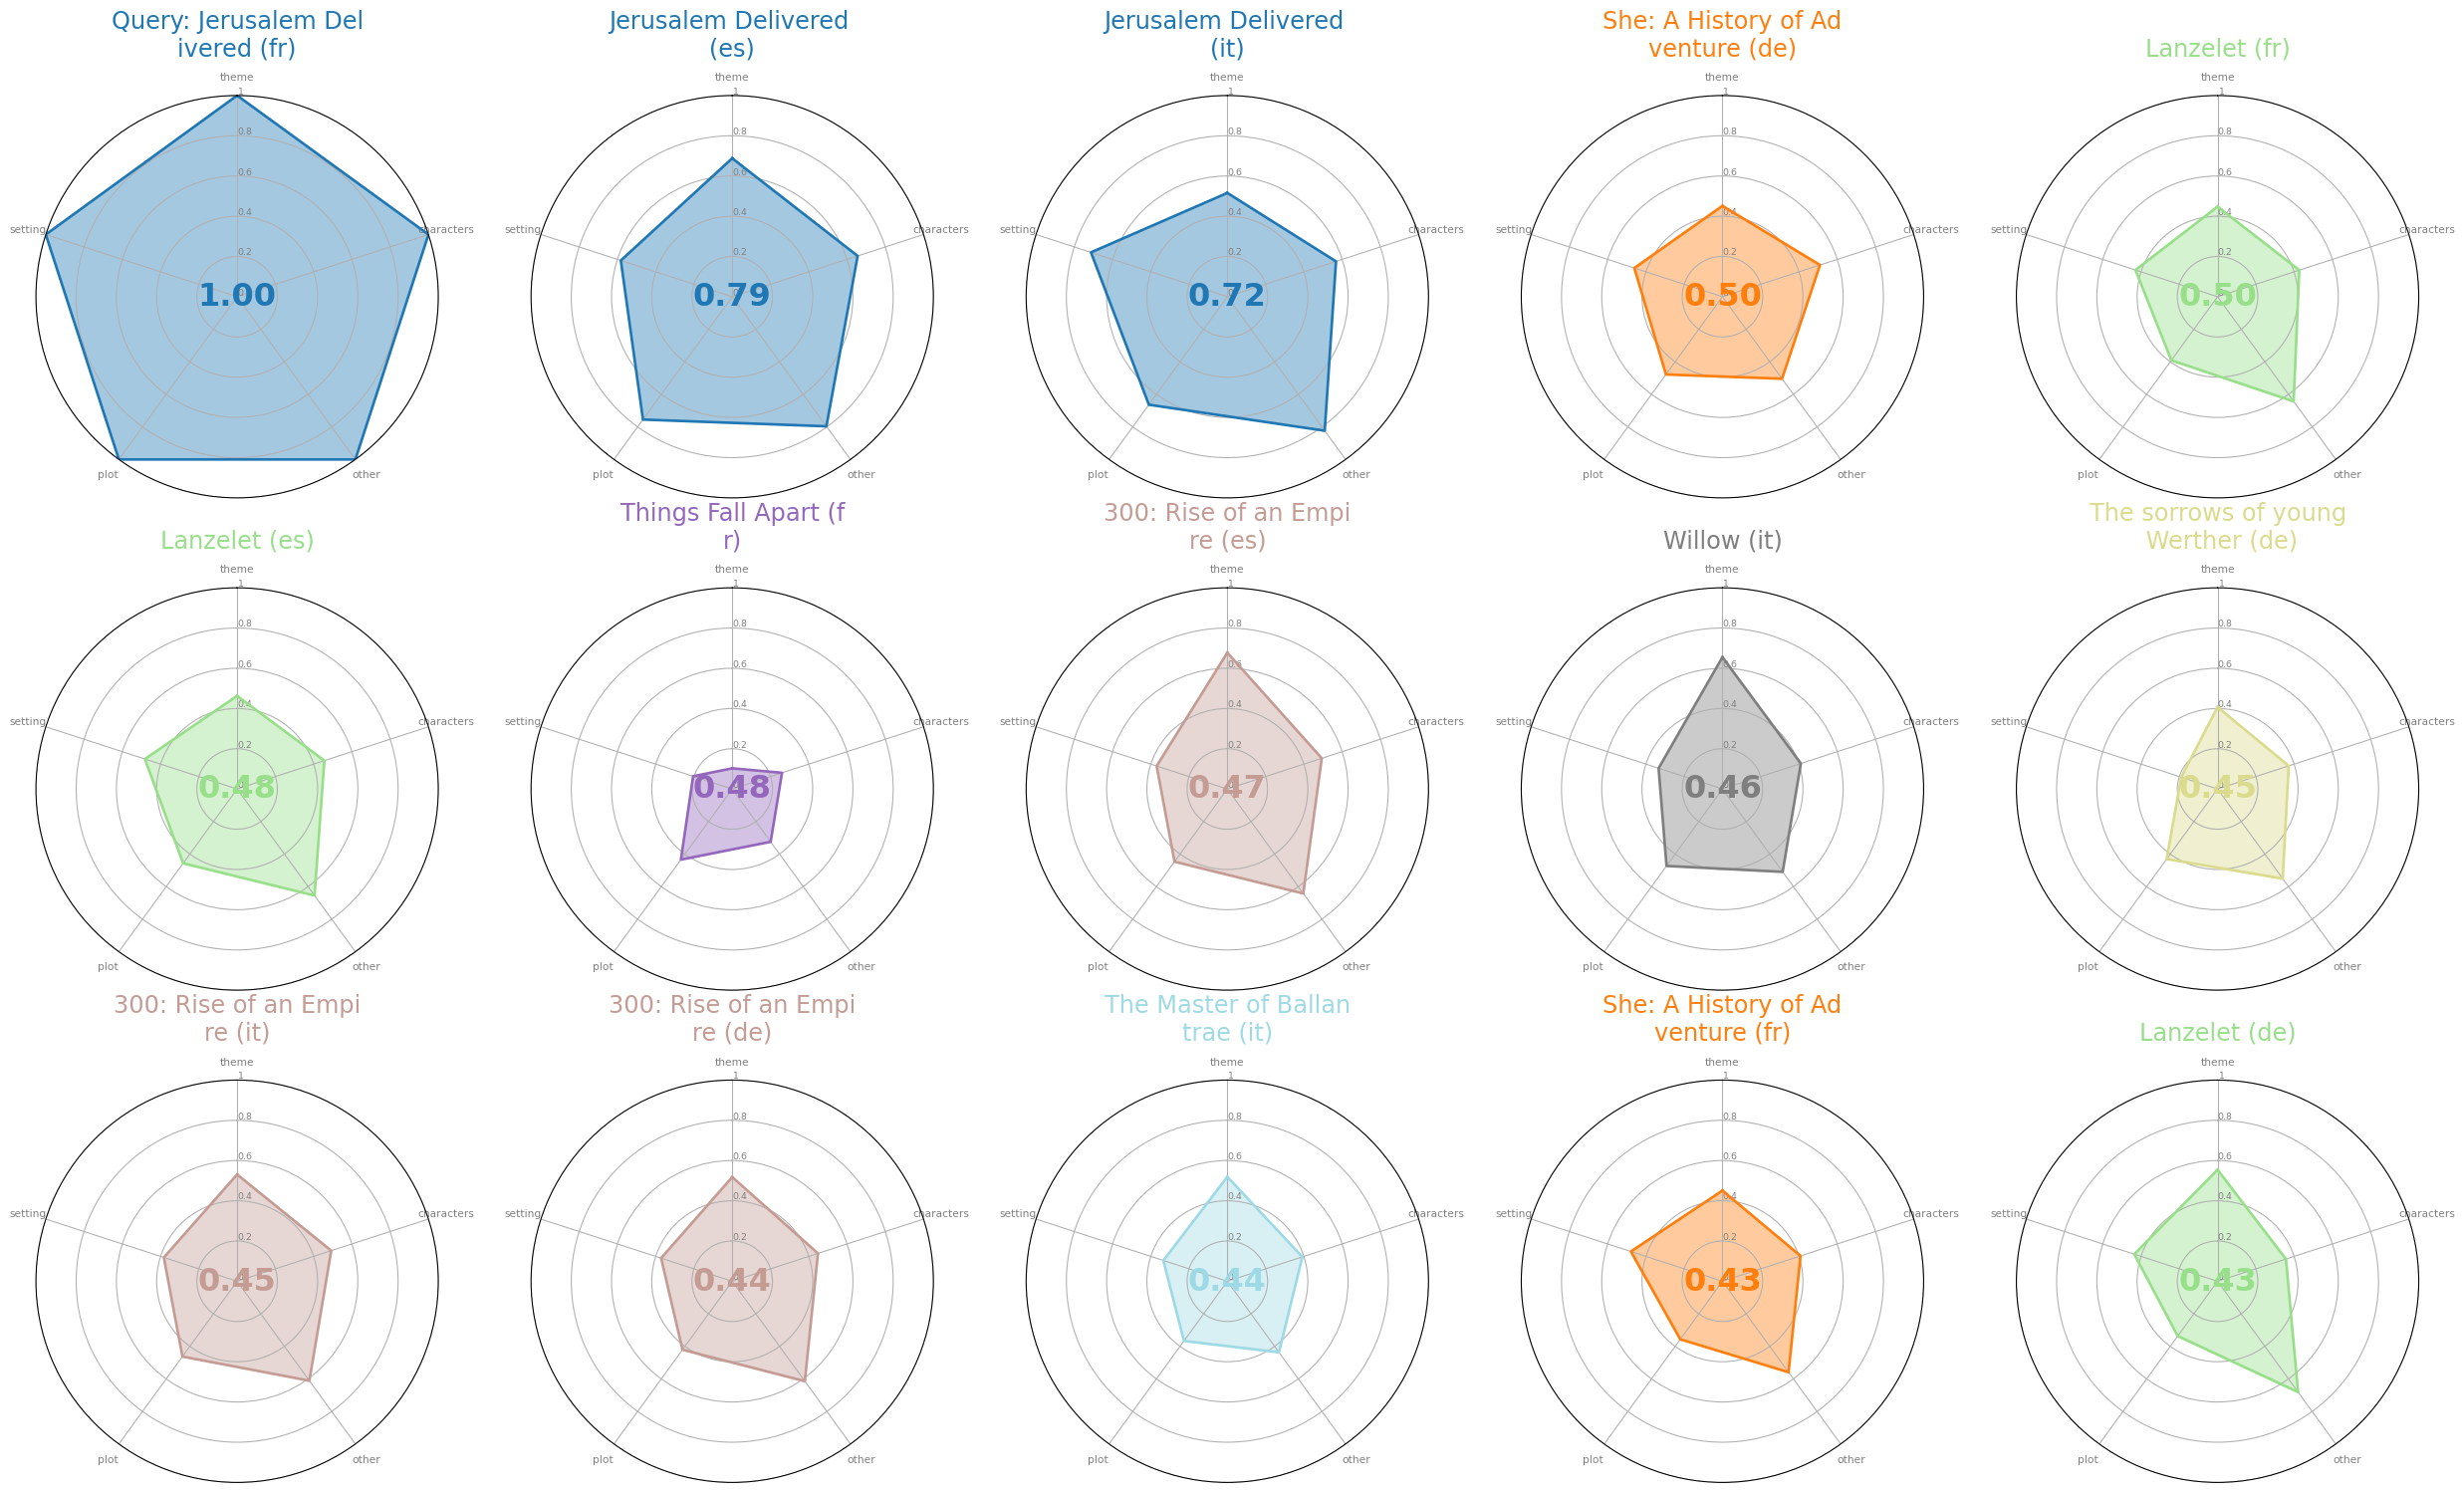

In [56]:
visualize_similarities(df_val, model, target_index=5, top_n=14, ascending=False)

C:\Users\emiel\AppData\Local\Temp\ipykernel_13876\3917670649.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_palette = cm.get_cmap("tab20", len(unique_titles))


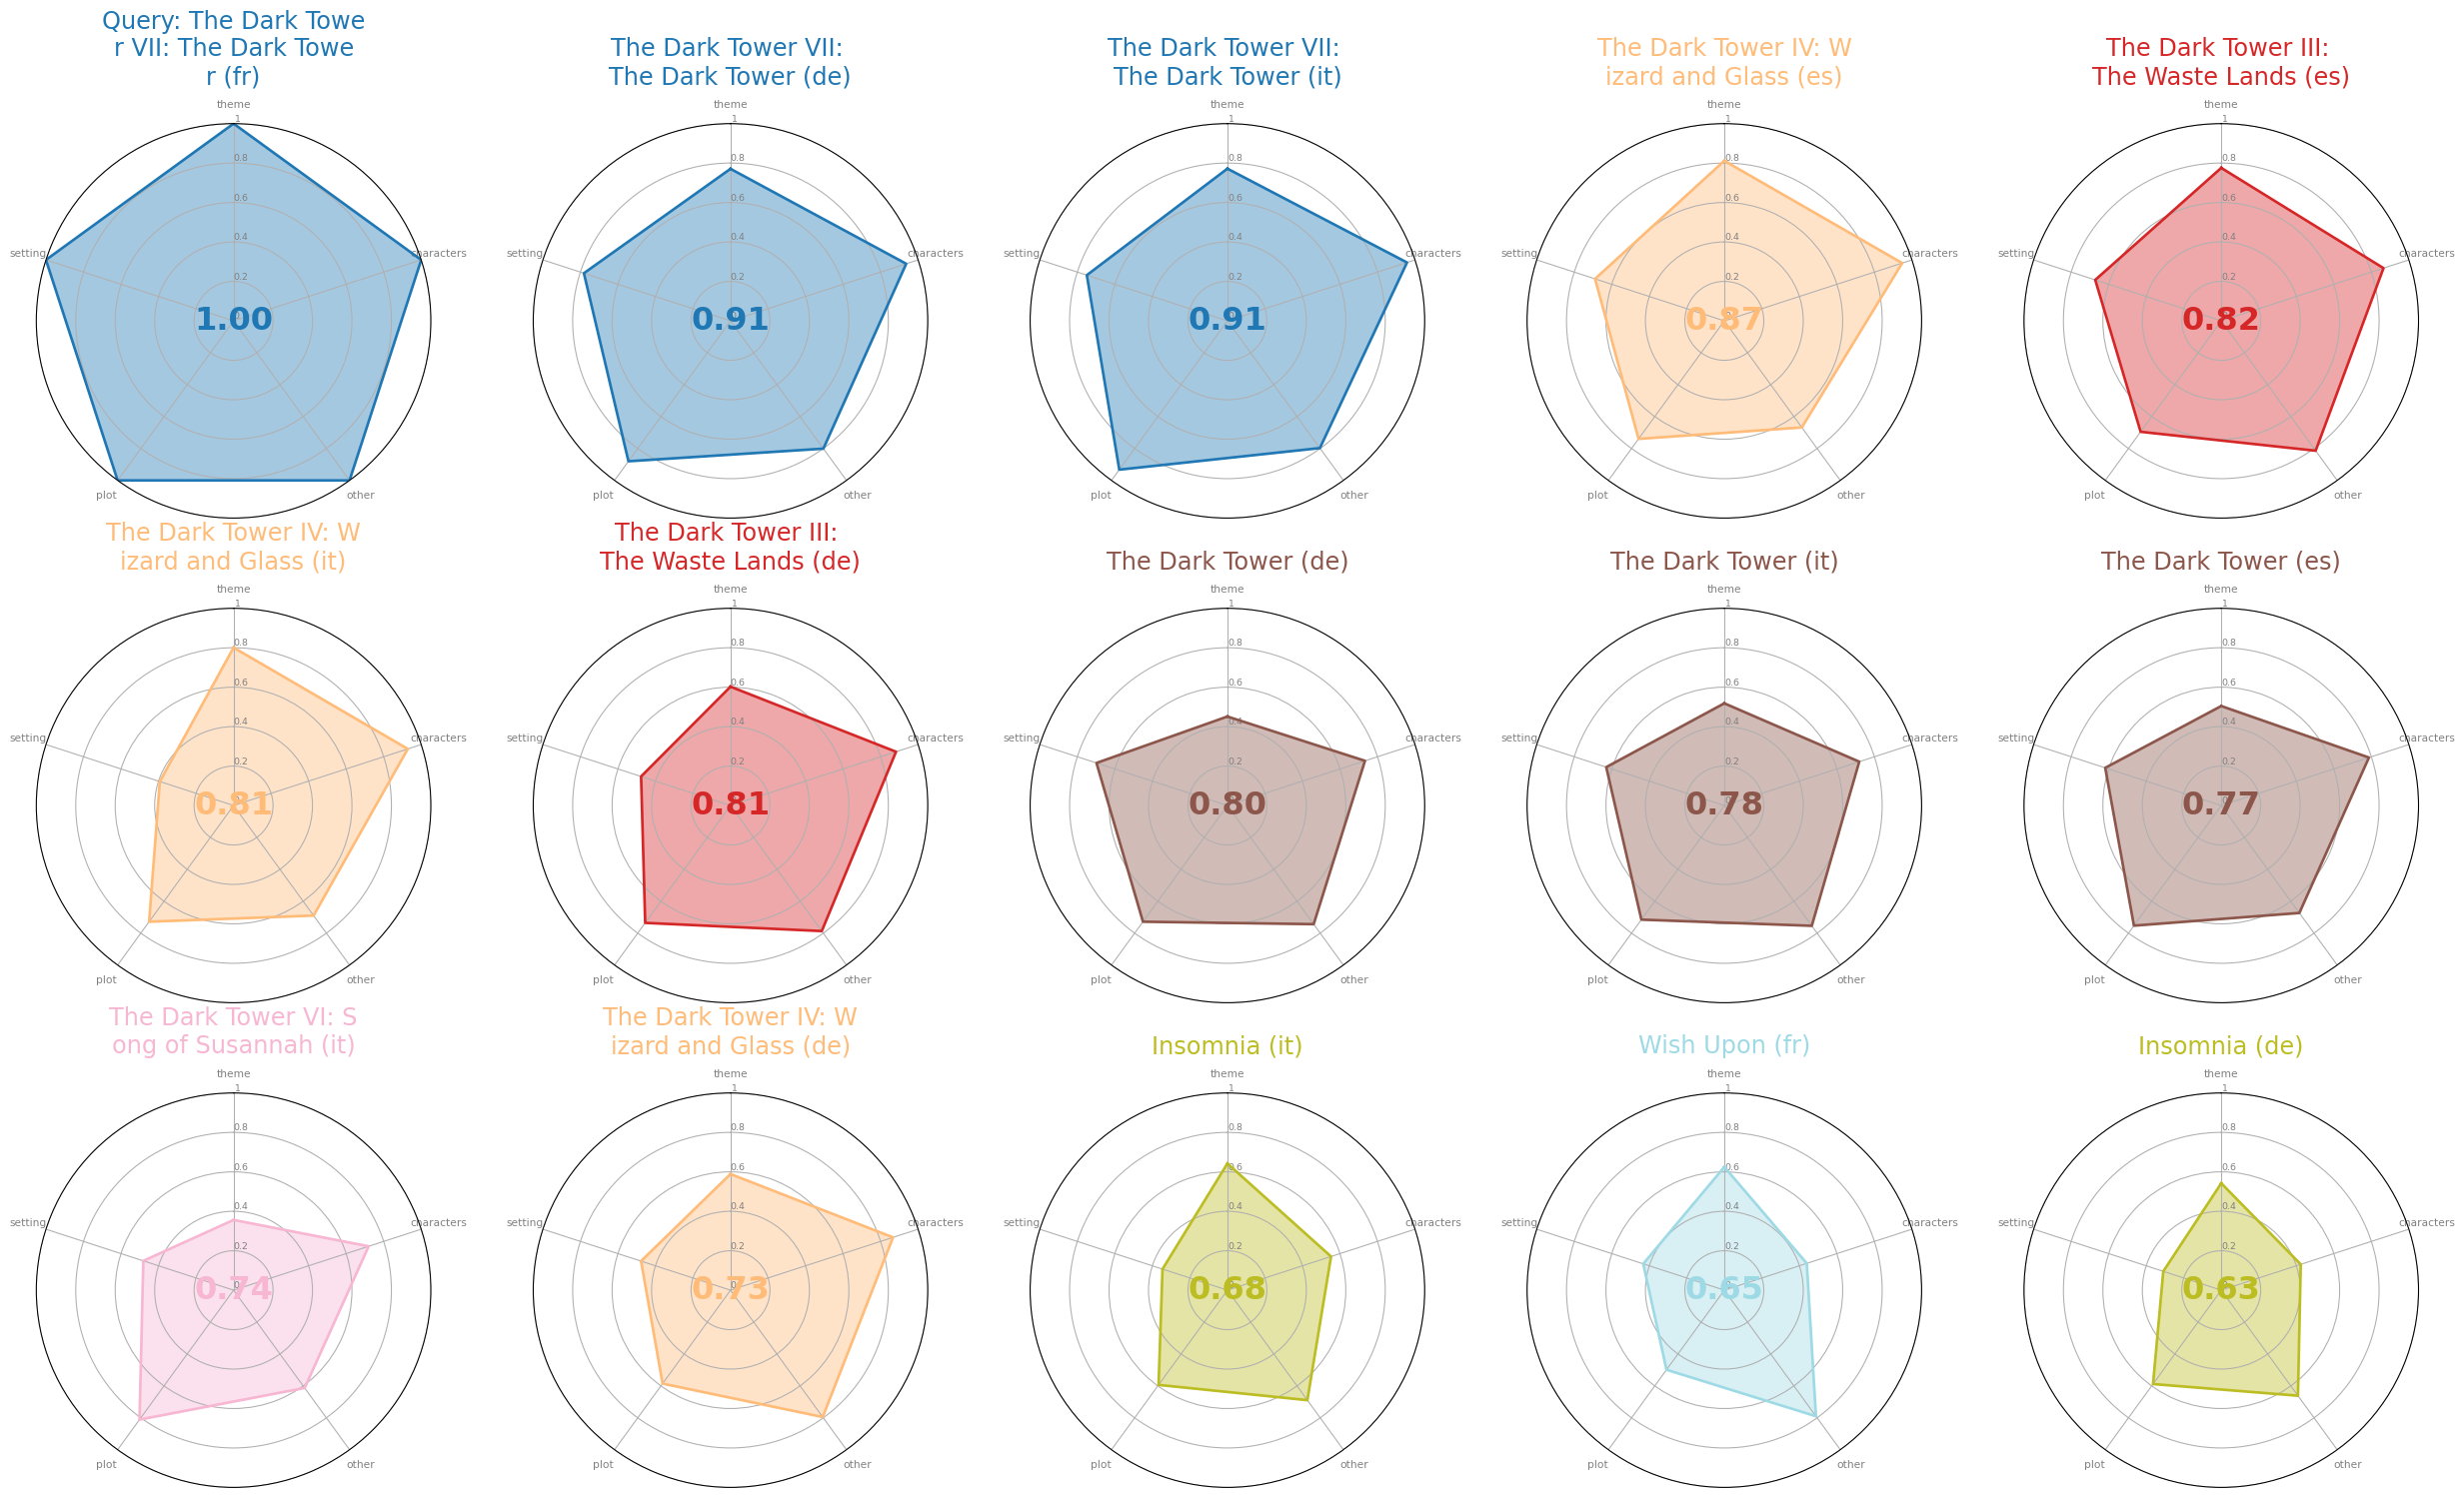

In [20]:
visualize_similarities(df, model, target_index=781, top_n=14, ascending=False)

C:\Users\emiel\AppData\Local\Temp\ipykernel_13876\3917670649.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_palette = cm.get_cmap("tab20", len(unique_titles))


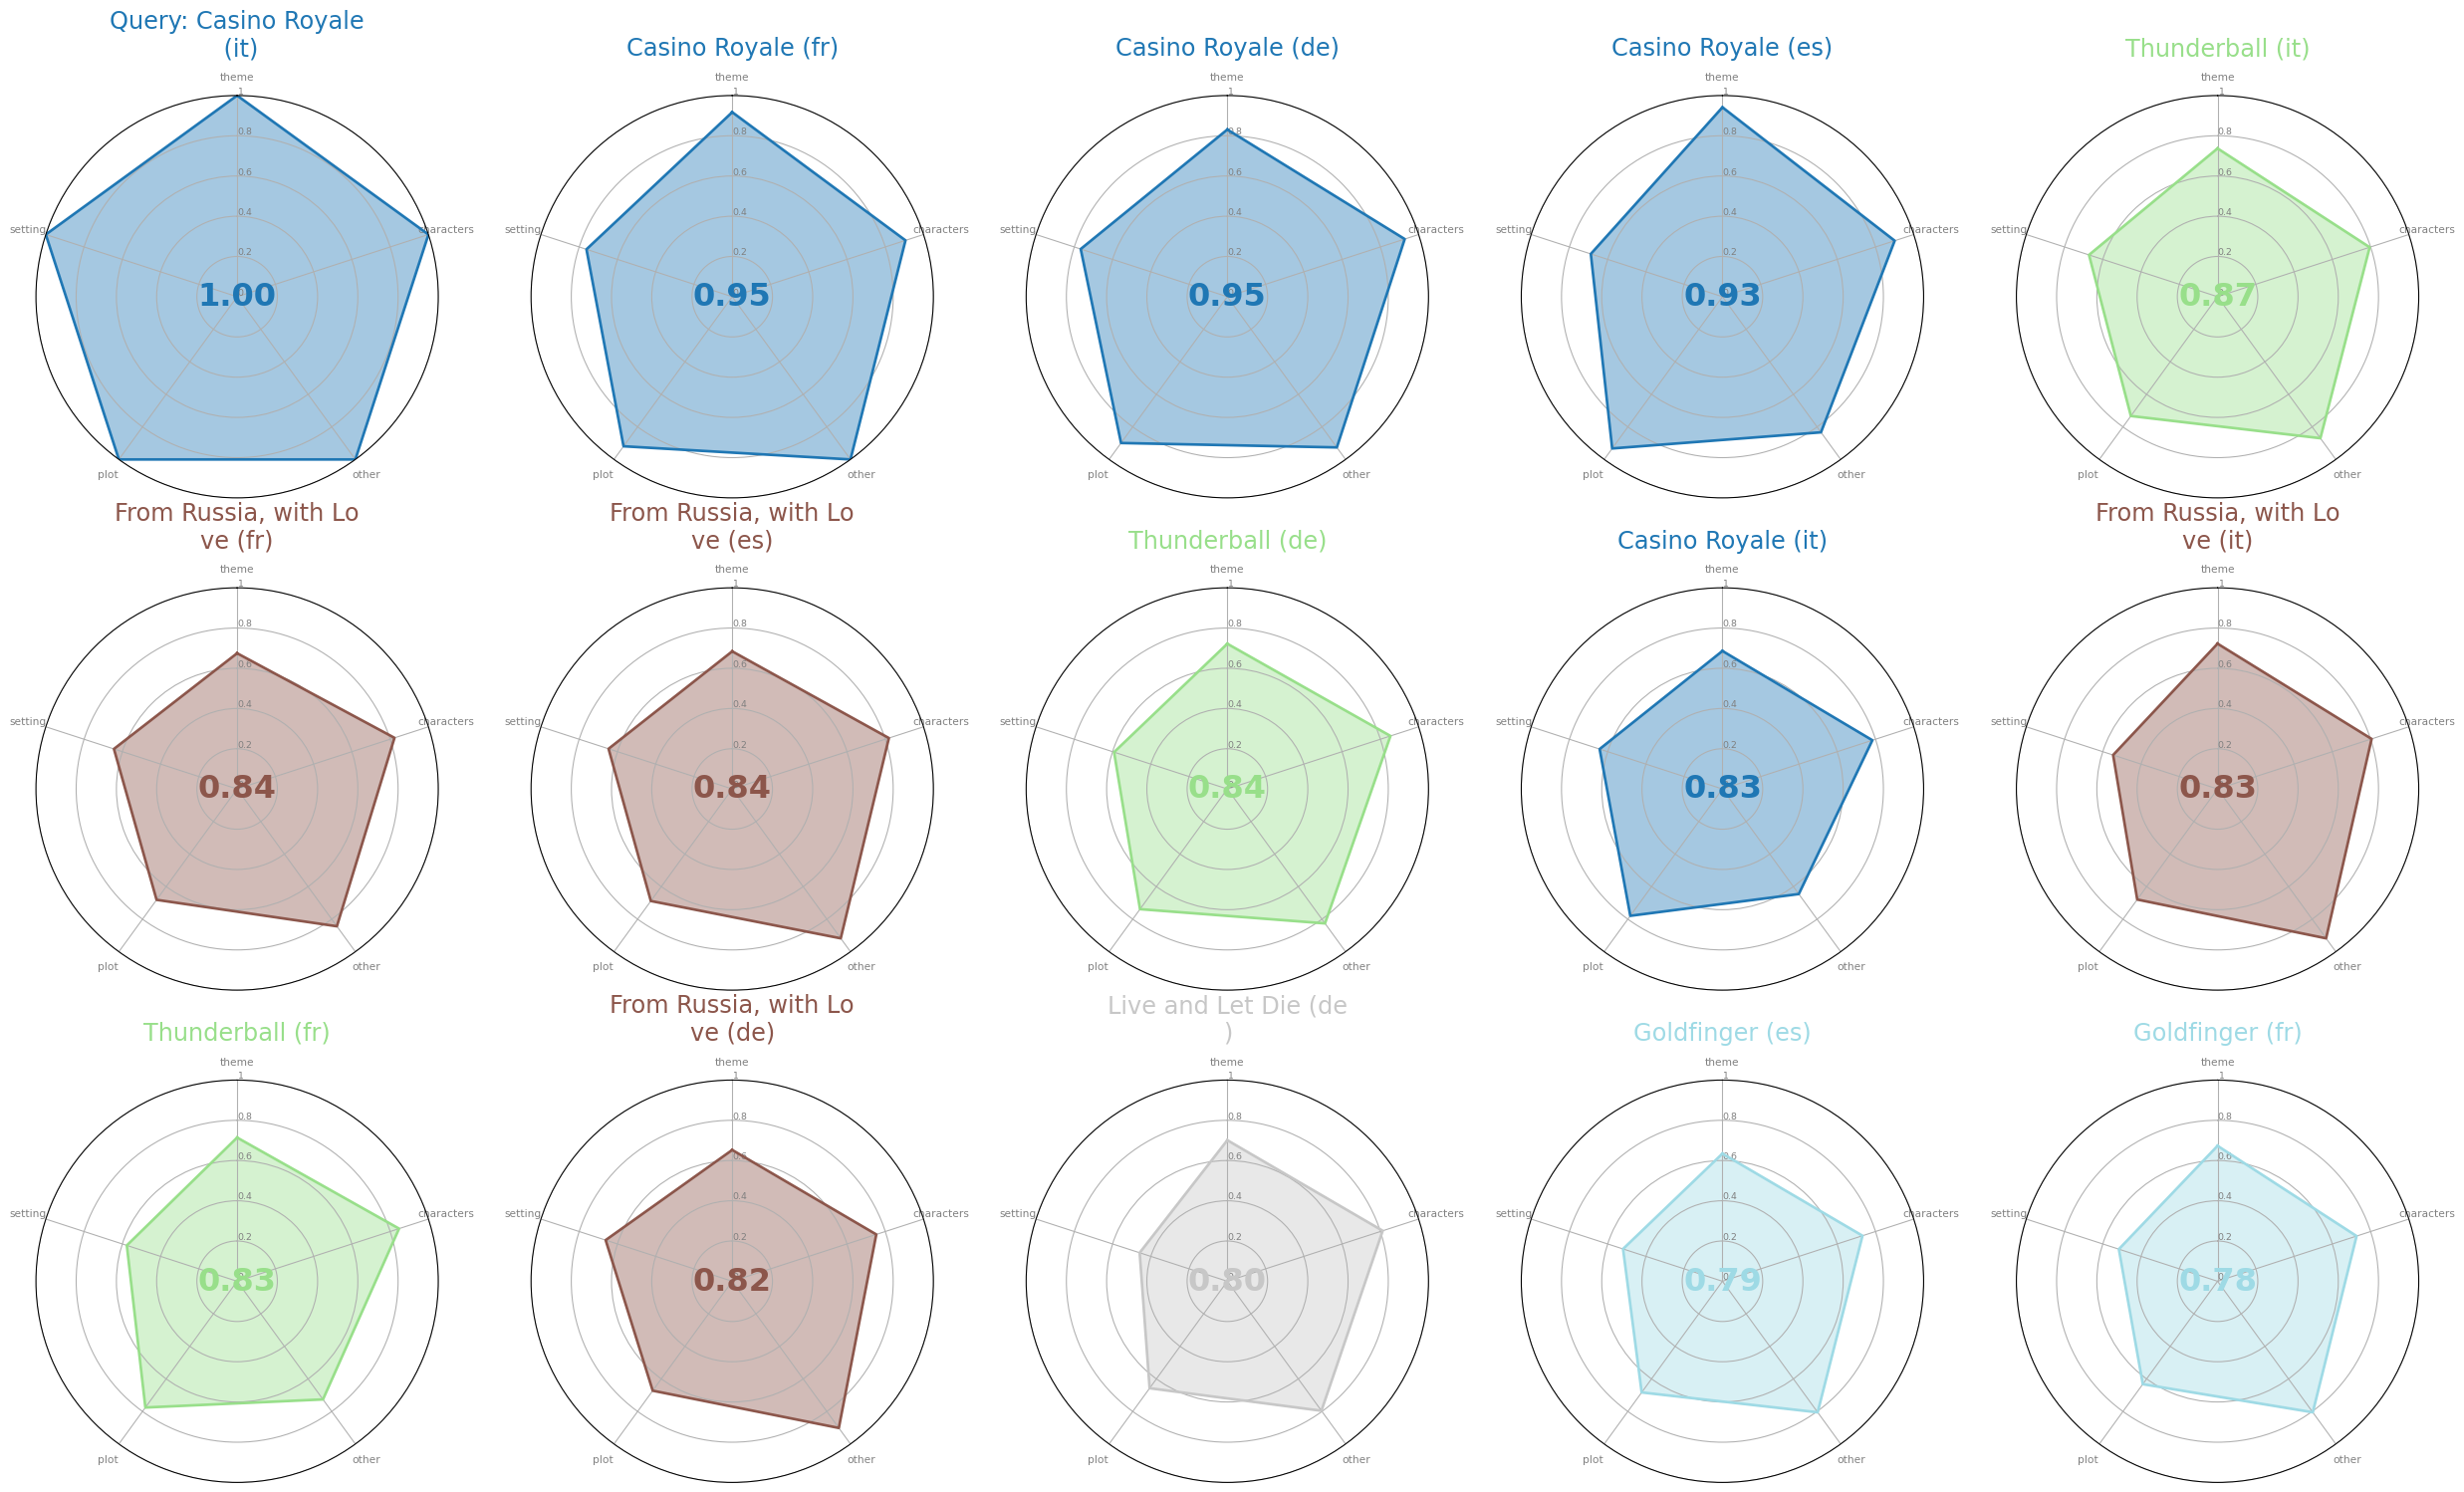

In [21]:
visualize_similarities(df, model, target_index=54, top_n=14, ascending=False)

In [22]:
attention_model.print_weights = True

In [23]:
#df,_ = embed_elements(df, model)
df = apply_attention(df, embedding_cols, attention_model)

tensor([[0.2504],
        [0.0951],
        [0.4642],
        [0.0743],
        [0.1159]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2723],
        [0.0791],
        [0.4690],
        [0.0775],
        [0.1021]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2015],
        [0.0657],
        [0.5211],
        [0.0903],
        [0.1214]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1855],
        [0.0674],
        [0.5105],
        [0.1040],
        [0.1326]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2061],
        [0.0725],
        [0.5122],
        [0.0906],
        [0.1187]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2095],
        [0.1023],
        [0.4948],
        [0.0905],
        [0.1029]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2093],
        [0.0898],
        [0.4918],
        [0.0982],
        [0.1110]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2013],
        [0.1230],
        [0.4791],
        [0.0891],
        [0.1075]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2467],
        [0.0731],
        [0.5

In [ ]:
df[df.title == 'Casino Royale']

In [ ]:
visualize_similarities(df, model, target_index=54, top_n=24, ascending=False)